<div align="center">
  <img src="https://upload.wikimedia.org/wikipedia/pt/a/a2/Brasao_UFPA.jpg" width="300">

  # **Universidade Federal do Pará**
  ## **Instituto de Tecnologia**
  ### **Faculdade de Engenharia de Computação e Telecomunicações**

  ---

  # **Disciplina:** Inteligência Computacional
  ### **Professor:** Dr. Aldebaro Barreto da Rocha Klautau Jr.

  ---

  ## 📑 **Tema:** Estratégias de Decodificação para Controlar a Aleatoriedade
  ### *(**Parâmetros de Inferência:** Temperatura, Amostragem Top-K, Amostragem Top-P)*

</div>

**Data:** 10 de Fevereiro de 2026  

---

### **Resumo do Notebook**
Este notebook apresenta uma análise prática sobre como diferentes parâmetros de decodificação influenciam a geração de texto em modelos de linguagem (LLMs), focando no balanço entre determinismo e criatividade (aleatoriedade).

**Pacote necessário:**

In [ ]:
# Importa a biblioteca principal do PyTorch.
# PyTorch é um framework de aprendizado de máquina de código aberto
# que é amplamente utilizado para construir e treinar redes neurais,
# incluindo modelos de linguagem grandes (LLMs).
import torch

# Importa a biblioteca matplotlib.pyplot, que é usada para criar visualizações estáticas,
# interativas e animadas em Python. É comumente usada para plotar dados.
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

## **1 - Vocabulário Artificial e Amostragem Probabilística**

Antes de prosseguirmos na explicação dos **Parâmetros de Inferência**, devemos definir sobre qual vocabulário iremos trabalhar para ilustrar a amostragem probabilística, criaremos um pequeno vocabulário para fins de visualização e para facilitar o ensino:

<div align="center">
  <table style="width: 100%; max-width: 800px; border-collapse: collapse; font-family: sans-serif; border: 2px solid #4A90E2;">
    <thead>
      <tr style="background-color: #f8f9fa; font-size: 24px;">
        <th style="border: 2px solid #4A90E2; padding: 20px; color: #4A90E2;">Token</th>
        <th style="border: 2px solid #4A90E2; padding: 20px; color: #4A90E2;">ID-Token</th>
      </tr>
    </thead>
    <tbody style="font-size: 20px; font-weight: bold;">
      <tr><td style="border: 1px solid #4A90E2; padding: 15px; color: #4A90E2;">a</td><td style="border: 1px solid #4A90E2; padding: 15px; color: #4A90E2;">0</td></tr>
      <tr><td style="border: 1px solid #4A90E2; padding: 15px; color: #4A90E2;">quero</td><td style="border: 1px solid #4A90E2; padding: 15px; color: #4A90E2;">1</td></tr>
      <tr><td style="border: 1px solid #4A90E2; padding: 15px; color: #4A90E2;">agora</td><td style="border: 1px solid #4A90E2; padding: 15px; color: #4A90E2;">2</td></tr>
      <tr><td style="border: 1px solid #4A90E2; padding: 15px; color: #4A90E2;">eu</td><td style="border: 1px solid #4A90E2; padding: 15px; color: #4A90E2;">3</td></tr>
      <tr><td style="border: 1px solid #4A90E2; padding: 15px; color: #4A90E2;">algum</td><td style="border: 1px solid #4A90E2; padding: 15px; color: #4A90E2;">4</td></tr>
      <tr><td style="border: 1px solid #4A90E2; padding: 15px; color: #4A90E2;">lugar</td><td style="border: 1px solid #4A90E2; padding: 15px; color: #4A90E2;">5</td></tr>
      <tr><td style="border: 1px solid #4A90E2; padding: 15px; color: #4A90E2;">casa</td><td style="border: 1px solid #4A90E2; padding: 15px; color: #4A90E2;">6</td></tr>
      <tr><td style="border: 1px solid #4A90E2; padding: 15px; color: #4A90E2;">ir</td><td style="border: 1px solid #4A90E2; padding: 15px; color: #4A90E2;">7</td></tr>
    </tbody>
  </table>
</div>

In [ ]:
# Define um dicionário chamado `vocab`.
# Este dicionário mapeia palavras (tokens) para seus IDs de token correspondentes (números inteiros).
# Em modelos de linguagem, cada palavra ou subpalavra no vocabulário recebe um ID único.
# O modelo opera com esses IDs numéricos em vez das strings de texto diretamente.
# A estrutura é { "palavra": ID_do_token }.
vocab = {
    "a": 0,  # A palavra "a" é mapeada para o ID de token 0.
    "quero": 1,   # A palavra "quero" é mapeada para o ID de token 1.
    "agora": 2,  # A palavra "agora" é mapeada para o ID de token 2.
    "eu": 3, # A palavra "eu" é mapeada para o ID de token 3.
    "algum": 4,  # A palavra "algum" é mapeada para o ID de token 4.
    "lugar": 5,   # A palavra "lugar" é mapeada para o ID de token 5.
    "casa": 6,   # A palavra "casa" é mapeada para o ID de token 6.
    "ir": 7,  # A palavra "ir" é mapeada para o ID de token 7.
}
# Cria um dicionário chamado `inverse_vocab`.
# Este dicionário é o inverso de `vocab`, mapeando IDs de token de volta para suas palavras correspondentes.
# Isso é útil para converter a saída numérica do modelo (IDs de token) de volta em texto legível por humanos.
# A estrutura é { ID_do_token: "palavra" }.
# {v: k for k, v in vocab.items()} é uma list comprehension de dicionário.
# Ela itera sobre os pares chave-valor (`k`, `v`) do dicionário `vocab` (`vocab.items()`).
# Para cada par, ela cria um novo par no `inverse_vocab` onde a chave é o valor (`v`) do `vocab`
# (o ID do token) e o valor é a chave (`k`) do `vocab` (a palavra).
inverse_vocab = {v: k for k, v in vocab.items()}

Em seguida, suponha que o LLM receba o contexto inicial **"eu quero ir a algum"** e gere os seguintes logits de próximo token:

In [ ]:
# Cria um tensor PyTorch chamado `next_token_logits`.
# Um tensor é a estrutura de dados fundamental no PyTorch, similar a arrays NumPy.
# Este tensor contém os "logits" previstos pelo modelo para o próximo token.
# Logits são as pontuações de saída bruta do modelo, uma para cada token possível
# no vocabulário. Eles não são probabilidades, mas sim valores que serão convertidos
# em probabilidades usando uma função como softmax.
# O tensor é unidimensional, onde cada elemento corresponde a um token no vocabulário.
# A ordem dos logits neste tensor corresponde à ordem dos tokens no dicionário `vocab` definido anteriormente.
next_token_logits = torch.tensor(
    [-0.4467,  # Logit para o token com ID 0 ("a")
    -0.2037,  # Logit para o token com ID 1 ("quero")
    -1.4283,  # Logit para o token com ID 2 ("agora")
     0.5096,  # Logit para o token com ID 3 ("eu")
     1.2092,  # Logit para o token com ID 4 ("algum")
     2.4009,  # Logit para o token com ID 5 ("lugar")
    -3.1302,  # Logit para o token com ID 6 ("casa")
    -1.3547,  # Logit para o token com ID 7 ("ir")
     ]
)
# A magnitude do logit indica a "confiança" do modelo de que o token correspondente
# é o próximo na sequência. Valores mais altos de logit implicam em maior probabilidade
# após a aplicação do softmax.

Conforme discutido em sala, na camada **Softmax distribuition** de uma LLM, convertemos os logits em probabilidades por meio da função `softmax` e obtemos o ID do token correspondente ao token gerado por meio da função `argmax`, que podemos então mapear de volta para texto por meio do vocabulário inverso:


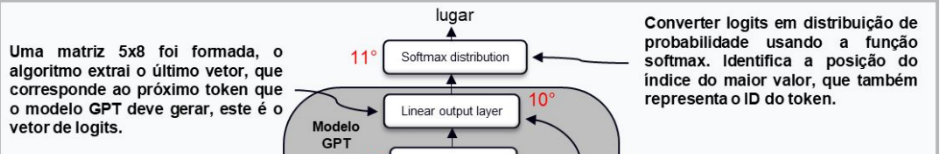

In [ ]:
# Aplica a função softmax aos logits.
# torch.softmax() converte um tensor de pontuações brutas (logits) em uma distribuição de probabilidade.
# Cada elemento na saída é um valor entre 0 e 1, e a soma de todos os elementos é 1.
# Isso transforma os logits que podem ter qualquer valor real em probabilidades que podem ser interpretadas.
# - next_token_logits: O tensor de logits de entrada.
# - dim=0: Especifica a dimensão ao longo da qual o softmax será calculado.
#          Neste caso, como `next_token_logits` é um tensor unidimensional, `dim=0`
#          aplica o softmax a todos os elementos do tensor. Se o tensor fosse bidimensional
#          (por exemplo, representando um lote de exemplos), você escolheria a dimensão
#          que corresponde ao vocabulário.
probas = torch.softmax(next_token_logits, dim=0)
# Encontra o índice (ID do token) com a maior probabilidade.
# torch.argmax() retorna o índice do maior valor ao longo de uma dimensão especificada.
# Neste caso, como `probas` é unidimensional (após o softmax), `torch.argmax(probas)`
# retorna o índice do elemento com a maior probabilidade. Este índice corresponde
# ao ID do token que o modelo prevê ser o mais provável.
# `.item()`: Extrai o valor escalar de um tensor PyTorch de um único elemento.
#            torch.argmax() retorna um tensor contendo um único valor, e `.item()`
#            converte este tensor para um tipo numérico padrão do Python.
next_token_id = torch.argmax(probas).item()
# Imprime a palavra correspondente ao ID do token previsto.
# inverse_vocab: O dicionário que mapeia IDs de token de volta para palavras.
# inverse_vocab[next_token_id]: Usa o ID do token encontrado no passo anterior como chave
#                               para procurar a palavra correspondente no dicionário `inverse_vocab`.
# print(...): Exibe a palavra encontrada no console.
print(inverse_vocab[next_token_id])

Como o maior valor logit e, consequentemente, a maior pontuação de probabilidade softmax estão na sexta posição (posição de índice 5, já que Python usa indexação 0), a palavra gerada é **"lugar"**.

Para implementar um processo de amostragem probabilística, podemos agora substituir `argmax` pela função `multinomial` no PyTorch:

In [ ]:
# Define a semente para o gerador de números aleatórios do PyTorch.
# Isso garante que a amostragem probabilística usando `torch.multinomial`
# seja reproduzível. Se você executar este código com a mesma semente,
# obterá a mesma sequência de números aleatórios e, portanto, o mesmo resultado de amostragem.
torch.manual_seed(120)
# Realiza a amostragem probabilística a partir da distribuição de probabilidades.
# torch.multinomial() sorteia `num_samples` elementos de um tensor de entrada,
# onde a probabilidade de sortear cada elemento é dada pelos valores no tensor de entrada.
# - probas: O tensor de probabilidades (resultante da aplicação do softmax aos logits).
#           Este tensor representa a distribuição de probabilidade sobre o vocabulário
#           para o próximo token. A soma de seus elementos deve ser 1.
# - num_samples=1: Especifica quantos elementos (IDs de token) devem ser sorteados.
#                  Neste caso, queremos sortear apenas um único token.
# O resultado é um tensor contendo os IDs dos tokens sorteados.
# `.item()`: Extrai o valor escalar do tensor resultante (que contém apenas um elemento)
#            e o converte para um tipo numérico padrão do Python.
next_token_id = torch.multinomial(probas, num_samples=1).item()
# Imprime a palavra correspondente ao ID do token sorteado.
# inverse_vocab: O dicionário que mapeia IDs de token de volta para palavras.
# inverse_vocab[next_token_id]: Usa o ID do token sorteado como chave para
#                               procurar a palavra correspondente no dicionário `inverse_vocab`.
# print(...): Exibe a palavra encontrada no console.
print(inverse_vocab[next_token_id])

A saída impressa é **"lugar"**, assim como antes. O que aconteceu? A função `multinomial` amostra o próximo token proporcionalmente à sua pontuação de probabilidade. Em outras palavras, **"lugar"** ainda é o token mais provável e será selecionado por `multinomial` na maioria das vezes, mas não o tempo todo. Para ilustrar isso, vamos implementar uma função que repete essa amostragem 1.000 vezes:

In [ ]:
# Define uma função para amostrar tokens a partir de uma distribuição de probabilidades e imprimir suas frequências.
#
# Parâmetros:
# - probas: Um tensor PyTorch contendo a distribuição de probabilidade sobre o vocabulário
#           para o próximo token. A soma de seus elementos deve ser 1.
def print_sampled_tokens(probas):
    # Define a semente para o gerador de números aleatórios do PyTorch dentro da função.
    # Isso garante que as amostragens realizadas dentro desta função sejam reproduzíveis
    # cada vez que a função é chamada.
    torch.manual_seed(123)
    # Realiza a amostragem de 1000 tokens a partir da distribuição de probabilidades.
    # [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]:
    # - range(1_000): Cria uma sequência de números de 0 a 999, indicando que o loop
    #   será executado 1000 vezes.
    # - torch.multinomial(probas, num_samples=1): Em cada iteração, sorteia um único
    #   elemento (um ID de token) do tensor `probas` com probabilidades dadas pelos
    #   valores em `probas`.
    # - .item(): Extrai o valor escalar (o ID do token sorteado) do tensor resultante.
    # - [...] (List Comprehension): Coleta os IDs de token sorteados em cada iteração
    #   em uma lista Python chamada `sample`.
    sample = [torch.multinomial(probas, num_samples=1).item()
              for i in range(1_000)]
    # Conta a frequência de cada ID de token sorteado na lista `sample`.
    # torch.tensor(sample): Converte a lista Python `sample` em um tensor PyTorch.
    # torch.bincount(...): Conta o número de ocorrências de cada valor inteiro não negativo
    #                      no tensor de entrada. O resultado é um tensor onde o índice
    #                      corresponde ao ID do token e o valor corresponde à sua frequência.
    # Por exemplo, se o ID do token 5 apareceu 500 vezes, `sampled_ids[3]` será 500.
    sampled_ids = torch.bincount(torch.tensor(sample))
    # Itera sobre os IDs de token que foram amostrados e suas frequências.
    # enumerate(sampled_ids): Retorna pares de (índice, valor) para o tensor `sampled_ids`.
    # - i: O índice, que corresponde ao ID do token.
    # - freq: O valor no índice `i`, que corresponde à frequência com que o token `i` foi amostrado.
    for i, freq in enumerate(sampled_ids):
        # Imprime a frequência e a palavra correspondente para cada ID de token amostrado.
        # f"{freq} x {inverse_vocab[i]}": Um f-string que formata a saída.
        # - {freq}: Exibe a frequência de amostragem do token.
        # - " x ": Um separador.
        # - {inverse_vocab[i]}: Usa o ID do token `i` para procurar a palavra correspondente
        #   no dicionário `inverse_vocab` e exibe a palavra.
        print(f"{freq} x {inverse_vocab[i]}")

# Chama a função `print_sampled_tokens` para executar o processo de amostragem e impressão.
# Passamos o tensor `probas` (a distribuição de probabilidade calculada anteriormente)
# como entrada para a função.
print_sampled_tokens(probas)

Como podemos ver, a palavra **lugar** é amostrada na maioria das vezes (602 de 1.000 vezes), mas os outros tokens também serão amostrados algumas vezes. Podemos controlar ainda mais o processo de distribuição e seleção por meio dos ***Parâmetros de Inferência*** das LLMs.

## **2 - Amostragem Top-k**

Para evitar a repetição monótona do token mais provável e refinar o processo de geração, utilizamos a estratégia de **Amostragem Top-K**. Esta técnica restringe o espaço de seleção do modelo apenas aos $k$ tokens mais prováveis do vocabulário, descartando candidatos irrelevantes que poderiam prejudicar a coerência do texto.

Mecanicamente, a abordagem Top-K identifica os tokens com os maiores valores de logit e substitui todos os demais por infinito negativo ($-\infty$). Essa máscara garante que, ao aplicarmos a função **Softmax**, as probabilidades dos tokens não selecionados sejam anuladas ($0$), forçando a redistribuição da massa de probabilidade exclusivamente entre os candidatos do topo do ranking. Como veremos na seção seguinte, essa distribuição filtrada pode ser posteriormente ajustada pelo parâmetro de **Temperatura** para controlar o nível de criatividade da saída.

Em código, podemos implementar o procedimento Top-K selecionando inicialmente os tokens com os maiores logits. Os valores e IDs dos três principais tokens, em ordem decrescente, são:

In [ ]:
# Define o valor de 'k' para a amostragem Top-k.
# Top-k restringe a amostragem aos k tokens mais prováveis.
top_k = 3
# Usa torch.topk para encontrar os k maiores valores (logits) e seus índices (posições).
# - next_token_logits: O tensor de logits de onde queremos selecionar os maiores valores.
# - top_k: O número de maiores valores a serem selecionados.
# - dim=-1: Especifica a dimensão ao longo da qual encontrar os maiores valores.
#           Em um tensor de logits de um LLM, a última dimensão (-1) corresponde
#           ao vocabulário. Neste exemplo unidimensional, dim=-1 ou dim=0
#           resultam no mesmo comportamento.
# torch.topk retorna uma tupla: (valores, índices).
# - top_logits: Um tensor contendo os `top_k` maiores valores de logit.
# - top_pos: Um tensor contendo os índices (IDs de token) correspondentes aos `top_k` maiores valores de logit.
top_logits, top_pos = torch.topk(next_token_logits, top_k, dim=-1)
# Imprime os valores dos logits selecionados (os k mais altos).
# Estes são os logits brutos para os tokens mais prováveis.
print("Top logits:", top_logits)
# Imprime as posições (IDs de token) dos logits selecionados.
# Estes são os IDs dos k tokens mais prováveis de acordo com o modelo.
print("Top posições:", top_pos)
# Imprime os tokens selecionados.
print("Top tokens:", [inverse_vocab[i.item()] for i in top_pos])

Em seguida, aplicamos a função `where` do PyTorch para definir os valores de logit dos tokens que estão abaixo do menor valor de logit dentro da nossa seleção dos três primeiros para infinito negativo (`-inf`). Os logits resultantes para o próximo token no vocabulário de nove tokens são:

In [ ]:
# Aplica uma máscara aos logits para implementar a amostragem Top-k.
# torch.where() é uma função que seleciona elementos de dois tensores de entrada
# com base em uma condição booleana.
#
# Parâmetros:
# - condition: Um tensor booleano (com a mesma forma do `next_token_logits`).
#              Para cada elemento, se a condição for True, o elemento correspondente
#              será selecionado do tensor `input`. Se a condição for False,
#              o elemento correspondente será selecionado do tensor `other`.
#              Neste caso, a condição é `next_token_logits < top_logits[-1]`.
#              `top_logits[-1]` obtém o menor valor entre os top-k logits (porque `top_logits`
#              é ordenado decrescentemente). A condição é True para todos os logits
#              que são menores que o menor dos top-k logits (ou seja, todos os logits
#              que NÃO estão entre os top-k).
# - input: O tensor de onde selecionar elementos quando a condição é True.
#          Aqui, `torch.tensor(float('-inf'))` cria um tensor contendo o valor de
#          infinito negativo para todos os elementos. Isso significa que, para os logits
#          que não estão entre os top-k (onde a condição é True), seus valores serão
#          substituídos por infinito negativo. Quando o softmax for aplicado a esses
#          novos logits, os tokens correspondentes terão probabilidade zero.
# - other: O tensor de onde selecionar elementos quando a condição é False.
#          Aqui, `next_token_logits` é o tensor original de logits. Isso significa que,
#          para os logits que estão entre os top-k (onde a condição é False), seus
#          valores originais são mantidos.
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)

# Imprime o tensor resultante `new_logits`.
# Este tensor agora contém os logits originais para os top-k tokens,
# e infinito negativo para todos os outros tokens. Isso efetivamente "mascara"
# os tokens menos prováveis antes de calcular as probabilidades.
print("Nova distribuição:", new_logits)

Abaixo criamos a função completa:

In [ ]:
def top_k_sampling(next_token_logits, k):
    """
    Implementa a amostragem Top-K filtrando os logits para manter apenas os 'k' mais prováveis.
    """

    # Primeiro, identificamos os 'k' maiores valores (logits) e suas posições.
    # O torch.topk retorna os valores ordenados de forma decrescente por padrão.
    top_logits, _ = torch.topk(next_token_logits, k)

    # Aplica uma máscara aos logits para implementar a amostragem Top-k.
    # torch.where() é uma função que seleciona elementos de dois tensores de entrada
    # com base em uma condição booleana.
    #
    # Parâmetros:
    # - condition: Um tensor booleano (com a mesma forma do `next_token_logits`).
    #              Para cada elemento, se a condição for True, o elemento correspondente
    #              será selecionado do tensor `input`. Se a condição for False,
    #              o elemento correspondente será selecionado do tensor `other`.
    #              Neste caso, a condição é `next_token_logits < top_logits[-1]`.
    #              `top_logits[-1]` obtém o menor valor entre os top-k logits (porque `top_logits`
    #              é ordenado decrescentemente). A condição é True para todos os logits
    #              que são menores que o menor dos top-k logits (ou seja, todos os logits
    #              que NÃO estão entre os top-k).
    # - input: O tensor de onde selecionar elementos quando a condição é True.
    #          Aqui, `torch.tensor(float('-inf'))` cria um tensor contendo o valor de
    #          infinito negativo para todos os elementos. Isso significa que, para os logits
    #          que não estão entre os top-k (onde a condição é True), seus valores serão
    #          substituídos por infinito negativo. Quando o softmax for aplicado a esses
    #          novos logits, os tokens correspondentes terão probabilidade zero.
    # - other: O tensor de onde selecionar elementos quando a condição é False.
    #          Aqui, `next_token_logits` é o tensor original de logits. Isso significa que,
    #          para os logits que estão entre os top-k (onde a condição é False), seus
    #          valores originais são mantidos.
    new_logits = torch.where(
        condition=next_token_logits < top_logits[-1],
        input=torch.tensor(float('-inf')),
        other=next_token_logits
    )

    return new_logits

A tabela abaixo mostra os logits após a aplicação da amostragem Top-K. Observe que os tokens que não estavam entre os `k` mais prováveis agora têm um logit de $-\infty$ (`-inf`), o que significa que suas probabilidades serão zero quando a função `softmax` for aplicada.

In [ ]:
# 1. Preparação dos Dados
# Supondo que 'next_token_logits' são os valores antes do Top-K
# e 'new_logits' são os valores após a máscara de -inf
probs_antes = torch.softmax(next_token_logits, dim=-1)
logits_filtrados = top_k_sampling(next_token_logits, k=3)
probs_depois = torch.softmax(logits_filtrados, dim=-1)

data = []
for i in range(len(vocab)):
    token = inverse_vocab[i]
    logit_antes = next_token_logits[i].item()
    logit_depois = new_logits[i].item()
    prob_antes = probs_antes[i].item()
    prob_depois = probs_depois[i].item()

    data.append({
        'ID': i,
        'Token': token,
        'Logit Original': logit_antes,
        'Logit Pós Top-K': logit_depois,
        'Prob. Original': prob_antes,
        'Prob. Pós Top-K': prob_depois
    })

df = pd.DataFrame(data)

# 2. Estilização para o Design da Imagem
def make_pretty(styler):
    # Título da Tabela
    styler.set_caption(f"Comparativo de Amostragem Top-K (k={top_k})")

    # Formatação de números (trata o -inf como texto)
    styler.format({
        'Logit Original': "{:.4f}",
        'Logit Pós Top-K': lambda x: "-inf" if x == float('-inf') else f"{x:.4f}",
        'Prob. Original': "{:.4f}",
        'Prob. Pós-K': "{:.4f}"
    })

    # Aplica o gradiente azul (Blues) igual ao da sua imagem
    # Usamos apenas as colunas de probabilidade para o mapa de calor
    styler.background_gradient(cmap='Blues', subset=['Prob. Original', 'Prob. Pós Top-K'])

    # Estilo do Cabeçalho e Células
    styler.set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#1a1a1a'), ('color', 'white'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '10px')]}
    ])

    return styler

# Exibição
display(make_pretty(df.style))

O gráfico abaixo ilustra visualmente como a amostragem Top-K altera a distribuição de probabilidade. As barras azuis (Probabilidades Originais) mostram a distribuição antes do Top-K, onde todos os tokens têm uma probabilidade diferente de zero. As barras laranja (Probabilidades com Top-K) mostram que apenas os `k` tokens mais prováveis (`lugar`, `algum`, `eu`) mantêm suas probabilidades (que são redistribuídas para somar 1), enquanto os demais tokens têm suas probabilidades zeradas, efetivamente removendo-os do processo de amostragem.

In [ ]:
# 1. Preparação das Probabilidades
# Calculamos a Softmax original (sem máscara) e a Softmax após o filtro Top-K
original_probas = torch.softmax(next_token_logits, dim=0).numpy()
top_k_probas = torch.softmax(new_logits, dim=0).numpy()

# 2. Configurações de Design e Espaçamento
bar_width = 0.25       # Largura das barras
inner_spacing = 0.15    # Espaço entre as barras do mesmo grupo (Original vs Top-K)
group_spacing = 1.8     # Espaço entre os grupos de tokens (ID 0, ID 1, etc)

x = torch.arange(len(vocab)).numpy()
x_positions = x * group_spacing

# 3. Criação da Figura
fig, ax = plt.subplots(figsize=(14, 7))

# Plotagem das Barras
rects1 = ax.bar(x_positions, original_probas, bar_width,
                label='Probabilidades Originais', color='#A9D0F5') # Azul Claro

rects2 = ax.bar(x_positions + bar_width + inner_spacing, top_k_probas, bar_width,
                label=f'Probabilidades com Top-K (k={top_k})', color='#084594') # Azul Escuro

# 4. Função para Adicionar os Valores (Labels) acima das Colunas
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        if height > 0.001: # Só mostra se o valor for relevante
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5), # 5 pontos de deslocamento vertical
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=11, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

# 5. Customização dos Eixos e Títulos
ax.set_title(f'Impacto da Amostragem Top-K na Distribuição de Probabilidade (Softmax)', fontsize=20, pad=30)
ax.set_ylabel('Probabilidade $P(x)$', fontsize=16)
ax.set_xlabel('IDs dos Tokens (e respectivo vocabulário)', fontsize=16)

# Centraliza o ID/Token embaixo do par de barras
center_offset = (bar_width + inner_spacing) / 2
ax.set_xticks(x_positions + center_offset)

# Rótulos do Eixo X: "ID \n (Token)"
labels = [f"{idx}\n({token})" for idx, token in zip(x.tolist(), vocab.keys())]
ax.set_xticklabels(labels, fontsize=14)
ax.tick_params(axis='y', labelsize=13)

# Ajuste do Limite Superior para não cortar os números
ax.set_ylim(0, max(top_k_probas.max(), original_probas.max()) * 1.35)

# Legenda e Grade
ax.legend(fontsize=14, loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## **3 - Temperatura**

O escalonamento de temperatura é um parâmetro que ajusta a "confiança" das previsões do modelo antes da conversão dos logits em probabilidades. De forma simplificada, ele atua como um controle de contraste: ele pode "achatar" a distribuição para torná-la mais diversa ou "acentuá-la" para torná-la mais focada.

Matematicamente, definimos a transformação dos logits $z_i$ de acordo com o seguinte sistema:

$$
f(z_i, T) =
\begin{cases}
\dfrac{z_i}{T} & \text{para } T > 0 \\
\text{argmax}(z) & \text{para } T = 0
\end{cases}
$$

* **Caso $T > 0$ (Amostragem Estocástica):** Dividimos cada logit pela temperatura.
    * Se **$T > 1$**, as diferenças entre as pontuações diminuem, resultando em uma escolha mais variada e criativa (maior incerteza).
    * Se **$T < 1$**, as diferenças são ampliadas, favorecendo os tokens de maior pontuação.
* **Caso $T = 0$ (Decodificação Gananciosa/Determinística):** No limite estatístico onde a temperatura atinge zero, deixamos de ter uma distribuição de probabilidades e passamos a selecionar apenas o token com o maior valor absoluto ($argmax$). O modelo torna-se 100% previsível, sempre emitindo a mesma resposta para o mesmo contexto.

In [ ]:
# Define uma função para aplicar a função softmax com escalonamento de temperatura aos logits.
# O escalonamento de temperatura é uma técnica usada em modelos de linguagem para controlar
# a aleatoriedade das previsões. Uma temperatura mais alta torna a distribuição de probabilidade
# mais suave (mais aleatória), enquanto uma temperatura mais baixa a torna mais nítida (mais determinística).
#
# Parâmetros:
# - logits: Um tensor PyTorch contendo os logits (pontuações brutas de saída) do modelo.
#           Estes são os valores antes de serem convertidos em probabilidades.
# - temperature: Um valor numérico (float) que controla a temperatura.
#                Deve ser maior que 0. Valores comuns estão entre 0.5 e 1.5.
#                temperature = 1.0 é equivalente ao softmax padrão.
def softmax_with_temperature(logits, temperature):

    if temperature > 0:
        # Escala os logits dividindo-os pela temperatura.
        # Se temperature > 1, os logits escalados serão menores em magnitude, tornando a
        # distribuição de probabilidade mais uniforme após o softmax (maior aleatoriedade).
        # Se temperature < 1, os logits escalados serão maiores em magnitude, tornando a
        # distribuição de probabilidade mais acentuada após o softmax (menor aleatoriedade).
        scaled_logits = logits / temperature
        # Aplica a função softmax aos logits escalados.
        # torch.softmax() converte o tensor de logits escalados em uma distribuição de probabilidade.
        # Cada elemento na saída é um valor entre 0 e 1, e a soma de todos os elementos é 1.
        # - scaled_logits: O tensor de logits após serem divididos pela temperatura.
        # - dim=0: Especifica a dimensão ao longo da qual o softmax será calculado.
        #          Neste caso, assume-se que a última dimensão dos logits corresponde
        #          ao vocabulário, mas para este exemplo unidimensional, `dim=0`
        #          aplica o softmax a todos os elementos. Em um LLM completo,
        #          você usaria `dim=-1`.
        return torch.softmax(scaled_logits, dim=0)

    else:
        # Se a temperatura for 0, retornamos uma distribuição one-hot para o token mais provável.
        # Isso simula um comportamento de amostragem gulosa (greedy decoding).
        idx_next = torch.argmax(logits, dim=0)
        # Cria um tensor de zeros com o mesmo tamanho dos logits.
        probabilities = torch.zeros_like(logits, dtype=torch.float32)
        # Define a probabilidade do token mais provável como 1.
        probabilities[idx_next] = 1.0
        return probabilities

Temperaturas maiores que 1 resultam em probabilidades de token distribuídas de forma mais uniforme, temperaturas menores que 1 resultam em distribuições supostamente mais confiáveis ​​(mais nítidas ou com mais picos) e temperatura igual a 0 retorna o token com maior probabilidade:

In [ ]:
# Define uma lista de diferentes valores de temperatura a serem usados para visualização.
# Note: Removi o T=0 puro para evitar erro de divisão por zero, usando um valor muito baixo (0.01) ou
# apenas mantendo os valores positivos que mostram a transição estatística.
temperatures = [1, 0.5, 5, 0]

# Calcula as probabilidades escaladas para cada temperatura definida na lista `temperatures`.
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]



In [ ]:
table_data = []
for i, T in enumerate(temperatures):
    probas_for_temp = scaled_probas[i]
    for token_id, prob in enumerate(probas_for_temp):
        token_name = inverse_vocab[token_id]
        table_data.append({
            'Temperatura': T,
            'ID do Token': token_id,
            'Token': token_name,
            'Probabilidade': prob.item()
        })

df_results = pd.DataFrame(table_data)

pivoted_df = df_results.pivot_table(index=['ID do Token', 'Token'], columns='Temperatura', values='Probabilidade')
pivoted_df.columns = [f'{col:.2f}' for col in pivoted_df.columns]

pivoted_df.columns.name = 'Temperatura'

display(pivoted_df.style.format("{:.4f}").background_gradient(cmap='Blues', axis=None))

A tabela acima demonstra como a escala de temperatura afeta a distribuição de probabilidade para cada token. Com temperaturas mais baixas (ex: 0.5), a probabilidade se concentra mais no token de maior probabilidade ('lugar'). Já com temperaturas mais altas (ex: 5), a distribuição se torna mais uniforme, dando mais chance a tokens menos prováveis.

Vamos ilustrar isso plotando as probabilidades originais juntamente com probabilidades escalonadas com diferentes valores de temperatura:

In [ ]:
# Cria um tensor PyTorch que representa os índices dos tokens (IDs).
x = torch.arange(len(vocab))

# Define a largura de cada barra no gráfico.
bar_width = 0.15

# Cria a figura com um tamanho maior para acomodar o texto ampliado.
fig, ax = plt.subplots(figsize=(12, 7))

# Loop que itera sobre os valores de temperatura e plota as barras lado a lado.
for i, T in enumerate(temperatures):
    # O deslocamento (x + i * bar_width) garante que as barras de cada T fiquem agrupadas por Token.
    ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperatura = {T}')

# Adiciona um título robusto ao gráfico.
ax.set_title('Impacto da Temperatura na Distribuição de Probabilidade (Softmax)', fontsize=18, pad=20)

# Define o rótulo para o eixo y e aumenta o tamanho da fonte.
ax.set_ylabel('Probabilidade $P(x)$', fontsize=16)
ax.set_xlabel('IDs dos Tokens (e respectivo vocabulário)', fontsize=16)

# Define as posições dos ticks no centro do grupo de barras de cada token.
ax.set_xticks(x + (len(temperatures) * bar_width) / 2 - bar_width/2)

# Cria os rótulos: "ID \n (Token)" - Ex: "0 \n (a)"
# vocab.keys() nos dá os tokens e 'x' nos dá os IDs.
labels = [f"{idx}\n({token})" for idx, token in zip(x.tolist(), vocab.keys())]

# Aplica os rótulos personalizados e aumenta o tamanho da fonte dos eixos.
ax.set_xticklabels(labels, fontsize=14)
ax.tick_params(axis='y', labelsize=13)

# Exibe a legenda com fonte aumentada.
ax.legend(fontsize=14, title_fontsize=15)

# Ajusta o layout para não cortar os textos grandes.
plt.tight_layout()

# Exibe a figura plotada.
plt.show()

Uma temperatura de 1 divide os logits por 1 antes de passá-los para a função `softmax` para calcular as pontuações de probabilidade. Em outras palavras, usar uma temperatura de 1 é o mesmo que não usar nenhuma escala de temperatura. Nesse caso, os tokens são selecionados com uma probabilidade igual às pontuações de probabilidade do softmax original por meio da função de amostragem `multinomial` no PyTorch. Por exemplo, para a configuração de temperatura 1, o token correspondente a **“lugar”** seria selecionado em cerca de 61% das vezes, já com temperatura igual a 0.5 seria selecionado em cerca de 89% das vezes.

## **4 - Amostragem Top-P**

A **Amostragem Top-P**, também conhecida como *Nucleus Sampling*, resolve uma limitação da amostragem Top-K: a dificuldade de escolher um valor fixo de $k$ que funcione bem para diferentes contextos. Enquanto o Top-K foca em um número fixo de candidatos, o Top-P foca na **massa de probabilidade acumulada**.

Nesta estratégia, selecionamos o menor conjunto de tokens (o "núcleo") cuja soma das probabilidades atinja um limite pré-definido $p$ (ex: $p=0.9$).

* **Se o modelo estiver muito confiante:** O núcleo será pequeno (talvez apenas 1 ou 2 tokens).
* **Se o modelo estiver incerto:** O núcleo se expande para incluir mais tokens até atingir a probabilidade $p$.

Assim como no Top-K, os tokens que ficam de fora desse "núcleo" têm seus logits substituídos por $-\infty$ para que sua probabilidade final seja zero.

Código Python para Implementação:

In [ ]:
def top_p_sampling(logits, top_p, min_tokens_to_keep=1, filter_value=-float("Inf")):
    """
    Implementação baseada na classe TopPLogitsWarper da biblioteca Transformers (Hugging Face).
    """

    # 1. Ordena os logits em ordem CRESCENTE (os menores primeiro).
    # sorted_logits: valores dos logits ordenados.
    # sorted_indices: posições originais dos tokens correspondentes aos logits ordenados.
    sorted_logits, sorted_indices = torch.sort(logits, descending=False, dim=-1)

    # 2. Converte os logits ordenados em probabilidades (softmax) e calcula a soma cumulativa (cumsum).
    # Como a ordem é crescente, a soma acumulada começa pelos tokens MENOS prováveis.
    cumulative_probs = sorted_logits.softmax(dim=-1).cumsum(dim=-1)

    # 3. Cria uma máscara booleana para identificar os tokens a serem removidos.
    # Se top_p é 0.9, queremos manter os 90% mais prováveis.
    # Logo, removemos os tokens que somados (do menor para o maior) representam os 10% iniciais (1 - 0.9).
    sorted_indices_to_remove = cumulative_probs <= (1 - top_p)

    # 4. Garante que o modelo mantenha pelo menos o número mínimo de tokens solicitado (padrão = 1).
    # O fatiamento [..., -min_tokens_to_keep:] acessa os últimos elementos (que são os mais prováveis).
    # Atribuir 0 (False) garante que eles NUNCA sejam marcados para remoção.
    if min_tokens_to_keep > 0:
        sorted_indices_to_remove[..., -min_tokens_to_keep:] = 0

    # 5. Reorganiza a máscara para a ordem original do vocabulário.
    # O método 'scatter' coloca os valores de sorted_indices_to_remove de volta nas posições
    # indicadas por sorted_indices, permitindo aplicar a máscara diretamente no tensor original.
    indices_to_remove = sorted_indices_to_remove.scatter(dim=-1, index=sorted_indices, src=sorted_indices_to_remove)

    # 6. Aplica a máscara de filtragem.
    # Os tokens marcados como True em 'indices_to_remove' têm seus logits substituídos por -inf.
    scores_processed = logits.masked_fill(indices_to_remove, filter_value)

    return scores_processed

Implementemos no exemplo a seguir:

In [ ]:
top_p = 0.9  # Queremos o núcleo que compõe 80% da probabilidade
logits_top_p = top_p_sampling(next_token_logits, top_p)
probas_top_p = torch.softmax(logits_top_p, dim=-1)

print(f"Tokens selecionados pelo Top-P (p={top_p}):")
for i, prob in enumerate(probas_top_p):
    if prob > 0:
        print(f"ID {i} ({inverse_vocab[i]}): {prob:.4f}")

In [ ]:
# Preparando dados para o DataFrame
data_top_p = []
for i in range(len(vocab)):
    data_top_p.append({
        'ID': i,
        'Token': inverse_vocab[i],
        'Logit Original': next_token_logits[i].item(),
        'Prob. Original': torch.softmax(next_token_logits, dim=-1)[i].item(),
        'Prob. Pós Top-P': probas_top_p[i].item()
    })

df_p = pd.DataFrame(data_top_p)

# Estilização
df_p.style.background_gradient(cmap='Blues', subset=['Prob. Original', 'Prob. Pós Top-P'])\
    .format({'Prob. Original': '{:.4f}', 'Prob. Pós Top-P': '{:.4f}', 'Logit Original': '{:.2f}'})\
    .set_caption(f"Análise de Amostragem Top-P (Threshold = {top_p})")

A tabela acima demonstra o efeito da amostragem Top-P (Nucleus Sampling) na distribuição de probabilidade dos tokens. Ela compara os logits e probabilidades originais com as probabilidades após a aplicação do Top-P. Observe que os tokens que não fazem parte do "núcleo" (cuja soma cumulativa de probabilidades não atingiu o limite `p`) têm suas probabilidades zeradas, restringindo as opções de amostragem aos tokens mais relevantes.

Enquanto a tabela anterior nos fornece os valores exatos dos logits e as probabilidades resultantes, a visualização gráfica abaixo permite observar de forma clara o fenômeno estatístico da **redistribuição de massa**.

In [ ]:
# 2. Cálculo dos dados
probas_original = torch.softmax(next_token_logits, dim=-1).numpy()

# 3. Configuração do Gráfico
tokens = list(vocab.keys())
ids = list(vocab.values())
x = torch.arange(len(vocab)).numpy()

bar_width = 0.35
inner_spacing = 0.02
group_spacing = 1.5
x_positions = x * group_spacing

fig, ax = plt.subplots(figsize=(14, 7))

# Plotagem das duas categorias
rects1 = ax.bar(x_positions, probas_original, bar_width,
                label='Original (Softmax)', color='#A9D0F5') # Azul claro

rects2 = ax.bar(x_positions + bar_width + inner_spacing, probas_top_p, bar_width,
                label=f'Pós Top-P (p={top_p})', color='#084594') # Azul escuro

# Adição de valores acima das colunas
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        if height > 0.001:
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=11, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

# Customização de eixos e títulos
ax.set_title(f'Impacto da Amostragem Top-P na Distribuição de Probabilidade (Softmax)', fontsize=20, pad=30)
ax.set_ylabel('Probabilidade $P(x)$', fontsize=16)
ax.set_xlabel('IDs dos Tokens (Vocabulário)', fontsize=16)

# Centralização dos nomes no eixo X
center_pos = x_positions + (bar_width + inner_spacing) / 2
labels = [f"{idx}\n({token})" for idx, token in zip(ids, tokens)]
ax.set_xticklabels(labels, fontsize=14)
ax.set_xticks(center_pos)

ax.set_ylim(0, max(probas_top_p.max(), probas_original.max()) + 0.15)
ax.legend(fontsize=14, title="Estratégia", title_fontsize=15)
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Note como a Amostragem Top-P atua como um "filtro dinâmico": os tokens que não compõem o núcleo de probabilidade ($p=0.9$) são completamente eliminados (suas barras azul-escuras desaparecem), forçando o modelo a redistribuir toda a probabilidade restante entre os candidatos selecionados. Este gráfico ilustra como o Top-P consegue "afunilar" as escolhas do modelo sem a rigidez de um valor $k$ fixo, adaptando-se à confiança da rede neural em cada passo da geração.

## **5 - Demonstração Prática: Modelo Phi-2 (Microsoft)**

Para finalizar o seu notebook com chave de ouro, vamos utilizar o modelo **Phi-2 da Microsoft**. Ele é ideal para este trabalho acadêmico por ser um modelo "Small Language Model" (SLM) extremamente eficiente, permitindo que você observe claramente como as mudanças nos parâmetros de Temperatura, Top-K e Top-P alteram a "personalidade" e a coerência das respostas em tempo real.

---

$\large \text{Descrição do Modelo Phi-2}$

Nesta seção, saímos do nosso vocabulário artificial para observar o impacto dos parâmetros de inferência em um modelo de linguagem real. Utilizaremos o **Phi-2**, um modelo de 2.7 bilhões de parâmetros que demonstra capacidades excepcionais de raciocínio e geração de texto.

---

### **4.1 - Configuração do Ambiente e Modelo**

Primeiro, carregamos o modelo e o tokenizador. O Phi-2 utiliza o ecossistema `transformers` da Hugging Face, facilitando a manipulação direta dos parâmetros que estudamos.

In [ ]:
!pip install deep_translator

In [ ]:
from deep_translator import GoogleTranslator
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig

In [ ]:
# 1. Definição do nome do modelo
model_name = "microsoft/phi-2"

# 2. Carregar o Tokenizador e configurar o padding
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

# 3. Carregar a CONFIGURAÇÃO primeiro
# Isso nos permite modificar as propriedades do modelo antes dele ser criado
config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
config.pad_token_id = tokenizer.eos_token_id # Injeção manual na configuração

# 4. Carregar o Modelo usando a configuração modificada
# Agora o modelo já "nasce" sabendo quem é o pad_token_id
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    config=config,
    torch_dtype="auto",
    trust_remote_code=True
).to("cuda" if torch.cuda.is_available() else "cpu")

print(f"Modelo Phi-2 carregado com sucesso!\nPad Token ID configurado como: {model.config.pad_token_id} (<|endoftext|>)")

In [ ]:
def gerar_e_traduzir(prompt, temp=1.0, k=50, p=1.0, traduzir=True):
    # 1. Preparação dos inputs
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # 2. Geração da resposta (Inferência com os parâmetros estudados)
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,
        do_sample=True if temp > 0 else False,
        temperature=temp if temp > 0 else None,
        top_k=k,
        top_p=p,
        pad_token_id=tokenizer.eos_token_id
    )

    # 3. Decodificação (ID -> Texto em Inglês)
    resposta_en = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # 4. Tradução (Opcional)
    if traduzir:
        try:
            # Traduz do inglês para o português brasileiro
            traducao = GoogleTranslator(source='en', target='pt').translate(resposta_en)
            return f"--- ORIGINAL (EN) ---\n{resposta_en}\n\n--- TRADUÇÃO (PT) ---\n{traducao}"
        except Exception as e:
            return f"Erro na tradução: {e}\n\nOriginal: {resposta_en}"

    return resposta_en

### **4.2 - Experimentação dos Parâmetros**

Agora, vamos testar como o modelo se comporta variando o que aprendemos. O prompt será: *"The future of artificial intelligence in Brazil is"*.

#### **Cenário A: Baixa Temperatura (Determinismo)**

Aqui o modelo deve ser mais conservador e técnico.

In [ ]:
# T=0.1 (Focado), Top-K desativado, Top-P desativado
print(gerar_e_traduzir("The future of artificial intelligence in Brazil is", temp=0.1))

#### **Cenário B: Alta Temperatura (Criatividade/Caos)**

O modelo explorará tokens menos prováveis, tornando-se mais imprevisível.

In [ ]:
# T=1.5 (Criativo), Top-K e Top-P abertos
print(gerar_e_traduzir("The future of artificial intelligence in Brazil is", temp=1.6, k=1000))

#### **Cenário C: Filtro Nucleus (Top-P) Ativado**

Observaremos uma geração mais equilibrada, onde o modelo corta a "cauda" de baixa probabilidade de forma dinâmica.

In [ ]:
# T=0.7, Top-K desativado, Top-P=0.9 (Núcleo de 90%)
print(gerar_e_traduzir("The future of artificial intelligence in Brazil is", temp=0.7, p=0.9, k=5))

## **Conclusão Comparativa**

Em uma visão probabilística, observamos que o controle da inferência não é sobre encontrar um "valor mágico", mas sim sobre gerenciar a **entropia** do sistema. Enquanto a **Temperatura** achata ou acentua a curva de probabilidade, o **Top-K** e o **Top-P** realizam uma poda (truncamento) estratégica do espaço amostral. No Phi-2, vimos que:

1. **Top-K** protege o modelo de escolher palavras absurdas em contextos de alta incerteza.
2. **Top-P** permite que o vocabulário se adapte ao contexto, sendo mais rigoroso quando a próxima palavra é óbvia e mais flexível quando há várias opções válidas.

## **Referências**

Abaixo estão listadas as principais referências bibliográficas e tecnológicas que fundamentaram o desenvolvimento deste notebook e a implementação dos parâmetros de inferência:

* **HOLTZMAN, Ari et al.** The Curious Case of Neural Text Degeneration. *In: International Conference on Learning Representations (ICLR)*, 2020. Disponível em: https://arxiv.org/abs/1904.09751. (Referência principal para a técnica de **Amostragem Top-P**).

* **HUGGING FACE.** Transformers Documentation: LogitsProcessor. Disponível em: https://huggingface.co/docs/transformers/main/en/internal/generation_utils. (Base para a implementação das funções de amostragem e uso do modelo **Phi-2**).

* **HUGGING FACE - Phi-2.** Transformers Documentation: **Phi-2**. Disponível em: https://huggingface.co/microsoft/phi-2.

* **MICROSOFT.** Phi-2: The surprising power of small language models. *Microsoft Research Blog*, 2023. Disponível em: https://www.microsoft.com/en-us/research/blog/phi-2-the-surprising-power-of-small-language-models/. (Referência do modelo utilizado na demonstração prática).

* **RASCHKA, Sebastian.** *Build a Large Language Model (From Scratch)*. Shelter Island, NY: Manning Publications, 2024. (Referência para os fundamentos de arquitetura de LLMs e estratégias de decodificação).

* **PYTORCH.**. Disponível em: https://pytorch.org/docs/stable/tensors.html. (Referência técnica para as operações de tensores utilizadas nas máscaras de logits).